In [1]:
import math
import random
import qiskit
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit , execute , Aer, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram , plot_bloch_multivector
from math import sqrt , pi

In [2]:
def calculate_matrix(A, B, sequence, m, n):
    #A: the payoff matrix of the first player
    #B: the payoff matrix of the second player
    #sequence: the sequence indicating the actions that have positive probabilities
    #m: the number of rows in A/B
    #n: the number of columns in A/B
    sequence_list =list(sequence)
    for i in range(len(sequence_list)):
        sequence_list[i] = int(sequence_list[i])
    row  = sequence_list[:m]
    column = sequence_list[m:]
    row_number = sum(row)  #the row number of systems of linear equations
    column_number = sum(column)  ##the column number of systems of linear equations
    if row_number == 0 or column_number == 0:
        return False
    row_index = [0 for i in range(row_number)]
    column_index = [0 for i in range(column_number)]
    i = 0
    flag = 0
    while i < m:
        if row[i] == 1:
            row_index[flag] = i
            flag += 1
        i += 1
    i = 0
    flag = 0
    while i < n:
        if column[i] == 1:
            column_index[flag] = i
            flag += 1
        i += 1
    #A_new is for the row player, while B_new is for the column player
    A_new = [[0 for i in range(column_number)] for i in range(row_number)]
    A_new = np.mat(A_new)
    B_new = [[0 for i in range(column_number)] for i in range(row_number)]
    B_new = np.mat(B_new)
    for i in range(row_number):  #initialize A_new and B_new 
        for j in range(column_number):
            A_new[i, j] = A[row_index[i], column_index[j]]
            B_new[i, j] = B[row_index[i], column_index[j]]
    for i in range(row_number - 1):  #construct A_new s.t. A_new * x = b
        A_new[i] = A_new[i] - A_new[i+1]
    A_new[row_number - 1] = [1] * column_number
    B_new = B_new.T
    for i in range(column_number - 1):  #construct B_new s.t. B_new * x = b
        B_new[i] = B_new[i] - B_new[i+1]
    B_new[column_number - 1] = [1] * row_number
        
    #use numpy.linalg.lstsq, may have some error
    #x1: row players strategy, x2: column player's strategy
    #Consider the column player, calculate the row player's mixed strategy
    b1 = np.array([0] * column_number)
    b1[column_number - 1] = 1
    x1, residuals, rank, s = np.linalg.lstsq(B_new, b1, rcond=None)
    #Consider the row player, calculate the column player's mixed strategy
    b2 = np.array([0] * row_number)
    b2[row_number - 1] = 1
    x2, residuals, rank, s = np.linalg.lstsq(A_new, b2, rcond=None)
    
    print("start checking")
    #check the solution
    #check whether the probability is not negative
    for i in range(row_number):
        if x1[i] < 0:
            return False
    for i in range(column_number):
        if x2[i] < 0:
            return False
    print("probability >= 0")
    
    #check whether the solution is correct
    for i in range(column_number-1):  #row player's strategy
        temp = np.sum(np.array(B_new[i]) * x1)
        if temp > 10**(-10):
            return False
    if abs(np.sum(x1)-1) > 10**(-10):
        return False
    for i in range(row_number-1):  #column player's strategy
        temp = np.sum(np.array(A_new[i]) * x2)
        if temp > 10**(-10):
            return False
    if abs(np.sum(x2)-1) > 10**(-10):
        return False
    print("solution is correct")
    
    #check whether those with zero probabilities have fewer payoffs
    column_strategy = [0] * n
    for i in range(column_number):
        column_strategy[column_index[i]] = x2[i]
    row_strategy = [0] * m
    for i in range(row_number):
        row_strategy[row_index[i]] = x1[i]
    row_payoff = np.sum(np.array(A[row_index[0]]) * column_strategy)  #positive probability
    for i in range(m):
        temp = 0
        flag = 0
        #consider np.sum(np.array(A[i]) * column_strategy) with positive probability
        for j in range(n):
            if column[j] == 1:
                temp += A[i, j] * column_strategy[flag]
                flag += 1
        if row_payoff - temp  < -10**(-10):
            return False
    C = B.T
    column_payoff = np.sum(np.array(C[column_index[0]]) * row_strategy)  #positive probability
    for i in range(n):
        temp = 0
        flag = 0
        #consider np.sum(np.array(C[i]) * row_strategy) with positive probability
        for j in range(m):
            if row[j] == 1:
                temp += C[i, j] * row_strategy[flag]
                flag += 1
        if column_payoff - temp  < -10**(-10):  
            return False
    print("payoff is correct")
    
    #All is correct: Nash equilibrium
    return (row_strategy, column_strategy)

# oracle

In [3]:
#the original circuit
oracle = QuantumCircuit(5, 1)
oracle.x(1)
oracle.x(3)
oracle.mct(list(range(4)), 4)
oracle.measure(4, 0)
oracle.draw()

q_0: ───────■─────
     ┌───┐  │     
q_1: ┤ X ├──■─────
     └───┘  │     
q_2: ───────■─────
     ┌───┐  │     
q_3: ┤ X ├──■─────
     └───┘┌─┴─┐┌─┐
q_4: ─────┤ X ├┤M├
          └───┘└╥┘
c: 1/═══════════╩═
                0

In [4]:
#test whether this corcuit performs correctly
def init1(x):
    oracle = QuantumCircuit(5, 5)
    oracle.initialize(x, [0, 1, 2, 3])
    oracle.measure(list(range(4)), list(range(4)))
    oracle.x(1)
    oracle.x(3)
    oracle.mct(list(range(4)), 4)
    oracle.measure(4, 4)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(oracle, simulator, shots = 1)
    result = job.result()
    counts = result.get_counts()
    return (max(counts)[1:], max(counts)[0])  

In [5]:
#only 1010 will give an output 1 (Nash equilibrium)
count = [0, 0]
x = []
for i in range(16):
    x.append(0)
for i in range(16):
    x[i] = 1
    temp = init1(x)
    print(temp)
    count[int(temp[1])] += 1
    x[i] = 0
#print("0:", count[0], ", ", "1:", count[1])

('0000', '0')
('0001', '0')
('0010', '0')
('0011', '0')
('0100', '0')
('0101', '1')
('0110', '0')
('0111', '0')
('1000', '0')
('1001', '0')
('1010', '0')
('1011', '0')
('1100', '0')
('1101', '0')
('1110', '0')
('1111', '0')


# Grover's search 

In [6]:
#the original circuit
oracle = QuantumCircuit(5, 5)
oracle.x(4)
oracle.h(4)
oracle.x(1)
oracle.x(3)
oracle.mct(list(range(4)), 4)
oracle.x(1)
oracle.x(3)
oracle.draw()

q_0: ────────────■───────
     ┌───┐       │  ┌───┐
q_1: ┤ X ├───────■──┤ X ├
     └───┘       │  └───┘
q_2: ────────────■───────
     ┌───┐       │  ┌───┐
q_3: ┤ X ├───────■──┤ X ├
     ├───┤┌───┐┌─┴─┐└───┘
q_4: ┤ X ├┤ H ├┤ X ├─────
     └───┘└───┘└───┘     
c: 5/════════════════════

In [7]:
n = 4
qc3 = QuantumCircuit(n+1, n+1)

qc3.barrier()
qc3 += oracle
qc3.barrier()

#add qc2 to qc3
for i in range(n):
    qc3.h(i)
    qc3.x(i)
qc3.h(0)
qc3.mct(list(range(1, n)), 0)
qc3.h(0)
for i in range(n):
    qc3.x(i)
    qc3.h(i)
qc3.draw()

░                      ░ ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐
q_0: ─░─────────────■────────░─┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├
      ░ ┌───┐       │  ┌───┐ ░ ├───┤├───┤└───┘└─┬─┘├───┤├───┤└───┘
q_1: ─░─┤ X ├───────■──┤ X ├─░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
      ░ └───┘       │  └───┘ ░ ├───┤├───┤       │  ├───┤├───┤     
q_2: ─░─────────────■────────░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
      ░ ┌───┐       │  ┌───┐ ░ ├───┤├───┤       │  ├───┤├───┤     
q_3: ─░─┤ X ├───────■──┤ X ├─░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
      ░ ├───┤┌───┐┌─┴─┐└───┘ ░ └───┘└───┘          └───┘└───┘     
q_4: ─░─┤ X ├┤ H ├┤ X ├──────░────────────────────────────────────
      ░ └───┘└───┘└───┘      ░                                    
c: 5/═════════════════════════════════════════════════════════════

In [8]:
#one iteration
qc4 = QuantumCircuit(n+1, n+1)
qc4.x(4)
for i in range(n+1):
    qc4.h(i)
qc4 += qc3
qc4.measure(list(range(n)), list(range(n)))
qc4.draw()

┌───┐      ░                      ░ ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐   »
q_0: ┤ H ├──────░─────────────■────────░─┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├───»
     ├───┤      ░ ┌───┐       │  ┌───┐ ░ ├───┤├───┤└───┘└─┬─┘├───┤├───┤└┬─┬┘   »
q_1: ┤ H ├──────░─┤ X ├───────■──┤ X ├─░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├─┤M├────»
     ├───┤      ░ └───┘       │  └───┘ ░ ├───┤├───┤       │  ├───┤├───┤ └╥┘ ┌─┐»
q_2: ┤ H ├──────░─────────────■────────░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├──╫──┤M├»
     ├───┤      ░ ┌───┐       │  ┌───┐ ░ ├───┤├───┤       │  ├───┤├───┤  ║  └╥┘»
q_3: ┤ H ├──────░─┤ X ├───────■──┤ X ├─░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├──╫───╫─»
     ├───┤┌───┐ ░ ├───┤┌───┐┌─┴─┐└───┘ ░ └───┘└───┘          └───┘└───┘  ║   ║ »
q_4: ┤ X ├┤ H ├─░─┤ X ├┤ H ├┤ X ├──────░─────────────────────────────────╫───╫─»
     └───┘└───┘ ░ └───┘└───┘└───┘      ░                                 ║   ║ »
c: 5/════════════════════════════════════════════════════════════════════╩═══╩═»
                                                                         1   2 »
«        ┌─┐
«q_0: ───┤M├
«        └╥┘
«q_1: ────╫─
«         ║ 
«q_2: ────╫─
«     ┌─┐ ║ 
«q_3: ┤M├─╫─
«     └╥┘ ║ 
«q_4: ─╫──╫─
«      ║  ║ 
«c: 5/═╩══╩═
«      3  0

In [12]:
#check
#prisoner's dilemma
import numpy as np
A = np.mat('3,0; 5,1')
B = np.mat('3,5; 0,1')
m = 2
n = 2
sequence = '0101'
calculate_matrix(A, B, sequence, m, n)

start checking
probability >= 0
solution is correct
payoff is correct


([0, 1.0], [0, 1.0])

In [13]:
backend = Aer.get_backend('qasm_simulator')
shots = 1
results = execute(qc4, backend=backend, shots=shots).result()
answer = results.get_counts()
print(answer)
count = dict()
for i in answer:
    sequence = i[1: ]
print(sequence)
calculate_matrix(A, B, sequence, m, n)

{'00110': 1}
0110
start checking
probability >= 0
solution is correct
payoff is correct


([0, 1.0], [1.0, 0])

# Grover's search simulation result

{'00000': 53, '00001': 39, '00010': 49, '00011': 51, '00100': 44, '00101': 271, '00110': 46, '00111': 55, '01000': 45, '01001': 52, '01010': 53, '01011': 56, '01100': 43, '01101': 47, '01110': 59, '01111': 61}


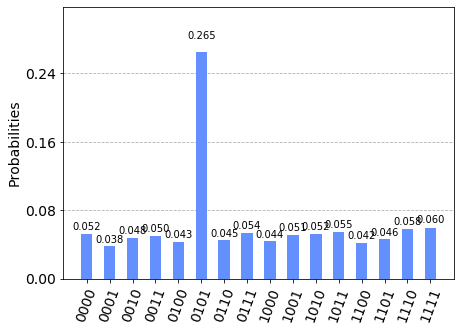

In [14]:
backend = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(qc4, backend=backend, shots=shots).result()
answer = results.get_counts()
print(answer)
count = dict()
for i in answer:
    if i[1: ] not in count:
        count[i[1: ]] = answer[i]
    else:
        count[i[1: ]] += answer[i]
plot_histogram(count)

[0.048828125, 0.056640625, 0.05859375, 0.037109375, 0.0419921875, 0.0576171875, 0.0537109375, 0.0419921875, 0.0673828125, 0.052734375, 0.0361328125, 0.0419921875, 0.076171875, 0.0634765625, 0.0478515625, 0.076171875, 0.05859375, 0.0341796875, 0.0439453125, 0.05859375]


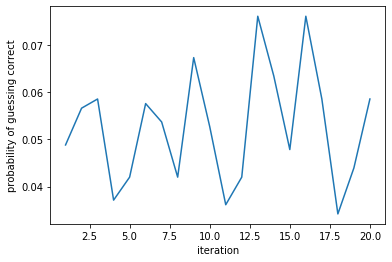

In [17]:
n = 4
#iteration from 1 to 20
x = [i for i in range(1, 21)]
data = []
for iteration in range(1, 21):
    qc4 = QuantumCircuit(n+1, n+1)
    qc4.x(4)
    for i in range(n+1):
        qc4.h(i)
    for i in range(iteration):
        qc4 += qc3
    qc4.measure([0, 1, 2, 3], [0, 1, 2, 3])
    backend = Aer.get_backend('qasm_simulator')
    shots = 1024
    results = execute(qc4, backend=backend, shots=shots).result()
    answer = results.get_counts()
    count = dict()
    for i in answer:
        if i[1: ] not in count:
            count[i[1: ]] = answer[i]
        else:
            count[i[1: ]] += answer[i]
    if "1010" in count:
        data.append(count["1010"]/1024)
    else:
        data.append(0)
print(data)
plt.plot(x, data)
plt.xlabel("iteration")
plt.ylabel("probability of guessing correct")
plt.show()

In [18]:
print("theoretical peak: ", pi / 4 * sqrt(2**4))

theoretical peak:  3.141592653589793


# combining all of them together

In [34]:
iteration = 3
number = 0
#prisoner's dilemma
A = np.mat('3,0; 5,1')
B = np.mat('3,5; 0,1')
m = 2
n = 2
while True:
    number += 1
    iteration = 3
    qc4 = QuantumCircuit(5, 5)
    qc4.x(4)
    for i in range(5):
        qc4.h(i)
    for i in range(iteration):
        qc4 += qc3
    qc4.measure([0, 1, 2, 3], [0, 1, 2, 3])
    backend = Aer.get_backend('qasm_simulator')
    shots = 1
    results = execute(qc4, backend=backend, shots=shots).result()
    answer = results.get_counts()
    for i in answer:
        sequence = i[1: ]
    final_result = calculate_matrix(A, B, sequence, m, n)
    print(final_result)
    if final_result != False:
        print(final_result)
        print("total number until finding NE: ", number)
        break

start checking
probability >= 0
False
start checking
probability >= 0
solution is correct
payoff is correct
([1.0, 0], [0, 1.0])
([1.0, 0], [0, 1.0])
total number until finding NE:  2


# average number until finding NE

In [32]:
iteration = 3
number = 0
#prisoner's dilemma
A = np.mat('3,0; 5,1')
B = np.mat('3,5; 0,1')
m = 2
n = 2
for i in range(1000):
    iteration = 3
    qc4 = QuantumCircuit(5, 5)
    qc4.x(4)
    for i in range(5):
        qc4.h(i)
    for i in range(iteration):
        qc4 += qc3
    qc4.measure([0, 1, 2, 3], [0, 1, 2, 3])
    backend = Aer.get_backend('qasm_simulator')
    shots = 1
    results = execute(qc4, backend=backend, shots=shots).result()
    answer = results.get_counts()
    for i in answer:
        sequence = i[1: ]
    final_result = calculate_matrix(A, B, sequence, m, n)
    if final_result != False:
        number += 1
print("average number until finding NE: ", 1000 / number)

start checking
probability >= 0
solution is correct
payoff is correct
start checking
start checking
probability >= 0
solution is correct
payoff is correct
start checking
probability >= 0
solution is correct
payoff is correct
start checking
probability >= 0
start checking
probability >= 0
start checking
probability >= 0
start checking
probability >= 0
start checking
probability >= 0
solution is correct
payoff is correct
start checking
probability >= 0
solution is correct
start checking
start checking
probability >= 0
solution is correct
payoff is correct
start checking
probability >= 0
start checking
probability >= 0
solution is correct
payoff is correct
start checking
probability >= 0
solution is correct
payoff is correct
start checking
probability >= 0
start checking
probability >= 0
start checking
probability >= 0
start checking
probability >= 0
start checking
probability >= 0
solution is correct
start checking
probability >= 0
solution is correct
payoff is correct
start checking
pro

start checking
probability >= 0
solution is correct
payoff is correct
start checking
probability >= 0
solution is correct
payoff is correct
start checking
probability >= 0
start checking
probability >= 0
start checking
probability >= 0
start checking
probability >= 0
start checking
probability >= 0
solution is correct
payoff is correct
start checking
probability >= 0
solution is correct
payoff is correct
start checking
probability >= 0
solution is correct
payoff is correct
start checking
probability >= 0
solution is correct
payoff is correct
start checking
probability >= 0
start checking
probability >= 0
solution is correct
start checking
start checking
probability >= 0
start checking
probability >= 0
solution is correct
start checking
probability >= 0
solution is correct
start checking
probability >= 0
start checking
probability >= 0
solution is correct
payoff is correct
start checking
probability >= 0
solution is correct
payoff is correct
start checking
probability >= 0
start checkin

start checking
probability >= 0
solution is correct
start checking
probability >= 0
solution is correct
payoff is correct
start checking
probability >= 0
solution is correct
payoff is correct
start checking
start checking
probability >= 0
start checking
probability >= 0
solution is correct
payoff is correct
start checking
probability >= 0
start checking
probability >= 0
solution is correct
start checking
probability >= 0
start checking
probability >= 0
solution is correct
payoff is correct
start checking
probability >= 0
solution is correct
payoff is correct
start checking
probability >= 0
solution is correct
payoff is correct
start checking
probability >= 0
start checking
probability >= 0
solution is correct
payoff is correct
start checking
probability >= 0
solution is correct
start checking
probability >= 0
solution is correct
payoff is correct
start checking
probability >= 0
start checking
probability >= 0
solution is correct
payoff is correct
start checking
probability >= 0
solutio

start checking
start checking
probability >= 0
solution is correct
payoff is correct
start checking
probability >= 0
solution is correct
payoff is correct
start checking
probability >= 0
start checking
probability >= 0
start checking
probability >= 0
start checking
probability >= 0
solution is correct
payoff is correct
start checking
start checking
probability >= 0
start checking
probability >= 0
start checking
probability >= 0
solution is correct
payoff is correct
start checking
probability >= 0
start checking
probability >= 0
start checking
probability >= 0
start checking
probability >= 0
solution is correct
start checking
probability >= 0
start checking
probability >= 0
solution is correct
payoff is correct
start checking
probability >= 0
start checking
probability >= 0
solution is correct
payoff is correct
start checking
probability >= 0
start checking
probability >= 0
solution is correct
payoff is correct
start checking
start checking
start checking
start checking
probability >= 0